# XRF Core Scan Calibration
We use the Univarite Log-Ratio Calibration of Weltje et al., 2008 to turn element intensities derived by XRF core scanning into element concentrations with depth. This is done with 25 calibrations samples, whose element concentrations were determined using ICP-OES.<br>
XRF scans are examined in depth-series for quality. Calcium carbonate percent data, derived from coulometry, are compared to CaO concentrations resulting from the calibration to assess quality.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import signal
from scipy import stats
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# Make Data Path and Figure Path
These are "input" and "output" paths for the program to read and write data.

In [8]:
data_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/'
figure_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Figures/'
table_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Tables/'

# Functions

In [9]:
from scipy import signal
def smooth(df,sig):
    gaus=signal.gaussian(3*sig,sig)
    gaus=gaus/sum(gaus)
    smooth_df=df.rolling(3*sig,min_periods=3*sig,center=True).apply(func=lambda x: np.dot(gaus,x),raw=True)
    return smooth_df

# Import XRF Data

In [10]:
xrf=pd.read_csv(data_path+'2cm_20s_xrf_data_counts.csv')
xrf.set_index('Depth (m CCSF)',drop=False,inplace=True)
xrf.sort_index(inplace=True)

In [11]:
old_xrf=pd.read_csv(data_path+'2mm_2s_xrf_data_counts.csv',low_memory=False,index_col='Depth CCSF (m)')
old_xrf=old_xrf[old_xrf['In the Splice?']==True]
old_xrf=old_xrf.sort_index().copy()
old_xrf=old_xrf[~old_xrf.index.duplicated(keep='first')].copy()
old_xrf['Top Offset (cm)']=old_xrf['position (mm)']*10
old_xrf['Depth (m CCSF)']=old_xrf.index

In [12]:
old_xrf.columns

Index(['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section', 'Sec half',
       'Section length (cm)', 'Top depth CCSF (m)', 'Bottom depth CCSF (m)',
       'Splice Tie Point -Samples Start At (cm)',
       'Splice Tie Point -Samples Stop At (cm)', 'In the Splice?',
       'position (mm)', 'sample surface', 'validity', 'E-gain', 'E-offset',
       'F-slope', 'F-offset', 'cps', 'MSE', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl',
       'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'As',
       'Br', 'Rb', 'Sr', 'Zr', 'Sb', 'Ba', 'La', 'Nd', 'Pb', 'Th', 'U',
       'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la', 'W la scat',
       'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc', 'Cr coh', 'Dt',
       'filename', 'Top Offset (cm)', 'Depth (m CCSF)'],
      dtype='object')

In [13]:
cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section', 'Sec half','Top Offset (cm)',
      'Section length (cm)', 'Top depth CCSF (m)', 'Bottom depth CCSF (m)','Depth (m CCSF)',
      'Splice Tie Point -Samples Start At (cm)',
       'Splice Tie Point -Samples Stop At (cm)', 'In the Splice?', 'sample surface', 'validity', 'E-gain', 'E-offset',
       'F-slope', 'F-offset', 'cps', 'MSE', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl',
       'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'As',
       'Br', 'Rb', 'Sr', 'Zr', 'Sb', 'Ba', 'La', 'Nd', 'Pb', 'Th', 'U',
       'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la', 'W la scat',
       'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc', 'Cr coh', 'Dt',
       'filename']

In [14]:
old_xrf=old_xrf[cols]

In [15]:
old_xrf.to_csv(table_path+'Table-4 2mm-2sec xrf data.csv',index=False)

# Clean the XRF Data
Here in this section will be the bulk of our data cleaning and preparation

### Sort by depth, delete duplicates, and save "cleaned" raw data
Saving the clean raw data now will allow other scientists, interested in reanalyzing my data, to have it in its most basic form

In [16]:
clean_xrf = xrf[~xrf.index.duplicated(keep='first')].sort_index().copy()
xrf=clean_xrf

In [17]:
xrf.columns

Index(['Depth (m CCSF)', 'Exp', 'Site', 'Hole', 'Type', 'Section',
       'SectionLabel', 'Top Offset (cm)', 'Section Top Depth (m CCSF)',
       'Section Bottom Depth (m CCSF)', 'filename', 'sample surface',
       'validity', 'E-gain', 'E-offset', 'F-slope', 'F-offset', 'cps', 'MSE',
       'Al', 'Si', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Ti', 'Fe', 'Co', 'Ni', 'Zn',
       'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Rh', 'Pd', 'Cd', 'Sb', 'Ce', 'Pr', 'Nd',
       'Tb', 'Tm', 'Lu', 'Hf', 'Os', 'Ir', 'Pt', 'Hg', 'Tl', 'Pb', 'Th', 'Pa',
       'U', 'Cr kb', 'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la', 'W la scat',
       'W lb1', 'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc', 'Cr coh', 'Dt'],
      dtype='object')

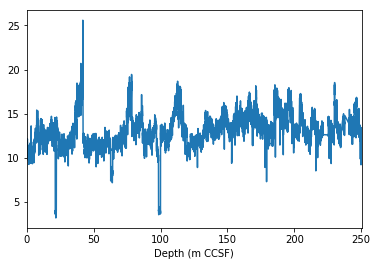

In [18]:
xrf['MSE'].plot()

# Visualize Complete XRF Dataset

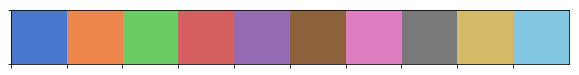

In [19]:
colors=sns.color_palette('muted',10)
colors_pale=['#C7D6F0','#F9DAC8','#D2EFD0','#F2CECE','#DFD2E8','#DCCFC4']
sns.palplot(colors)

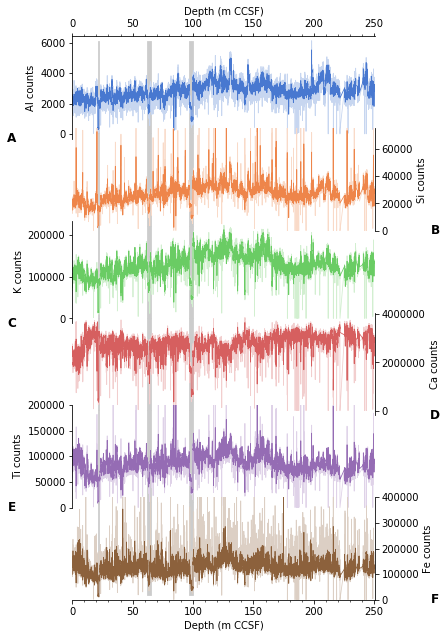

In [20]:
fig,axes=plt.subplots(nrows=6,figsize=(6,9))
sns.set_context('paper',font_scale=1.2)

lw=.8
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)

for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    xrf[e].plot(ax=axes[i],color=colors[i],lw=lw)
    (old_xrf[e]*10).plot(ax=axes[i],color=colors_pale[i],lw=lw,zorder=-2)
    axes[i].set_ylabel(e+' counts')
    axes[i].axvspan(xmin=21,xmax=22,ymin=.05,ymax=.95,color='#CCCCCC',zorder=-4)
    axes[i].axvspan(xmin=62,xmax=65,ymin=.05,ymax=.95,color='#CCCCCC',zorder=-4)
    axes[i].axvspan(xmin=97,xmax=100,ymin=.05,ymax=.95,color='#CCCCCC',zorder=-4)

labels=['A','C','E']
axs=[0,2,4]

for i in np.arange(0,3): 
    axes[axs[i]].annotate(labels[i],xy=(-.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')

labels=['B','D','F']
axs=[1,3,5]

for i in np.arange(0,3): 
    axes[axs[i]].annotate(labels[i],xy=(1+.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')

axes[1].set_ylim(0,75000)
axes[4].set_ylim(0,200000)
axes[5].set_ylim(0,400000)

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth (m CCSF)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth (m CCSF)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-2 counts.eps',dpi=1000,format='eps')

Notice the sections highlighted in grey have relatively low counts. Checking the raw data reveals they were scanned at low amperage.

# Problem Sections
It seems as if multiplying each of the 4 sections by a scalar, different for each section but identical for all 6 elements, does a relatively good job fixing the counts. Aluminum is an exception. Counts for aluminum are relatively low, and thus the signal/noise ratio is low. Scaling the elements should not affect ratios, commonly used for XRF core scanning, so this manipulation might not matter much. <br> <br> Additionally, we repair the quantity reflecting the degree of cohesive scatter ("Cr coh"), because we found that normalizing terrigenously derived elements (K,Fe,Ti), to this factor improves the correlation with the calibration samples. This is shown later. <br> <br> Here we show how we scaled each mis-scanned section:

In [21]:
e_list=['Al','Si','K','Ti','Fe']

#### Section D4H1

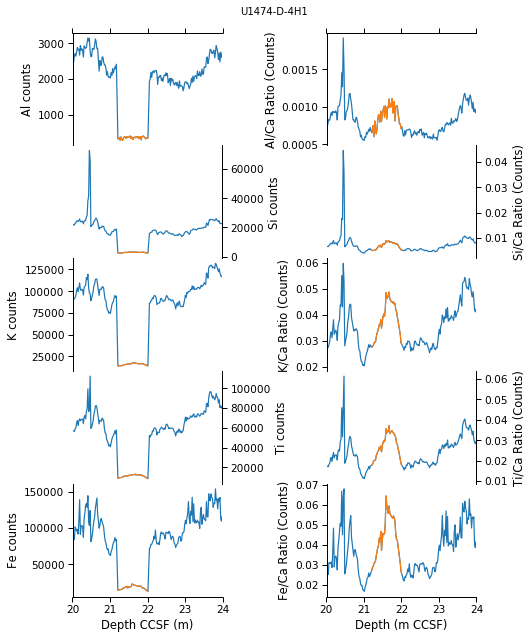

In [22]:
ids=xrf[xrf['SectionLabel'] == 'U1474D_4H1'].index

fig,axes=plt.subplots(ncols=2,nrows=5,figsize=(8,9),sharex=True)
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

for i in [0,1]:
    sns.despine(ax=axes[0,i],right=True,bottom=True,top=False)
    axes[0,i].patch.set_alpha(0)

for i in [0,1]:
    for i,ax in enumerate(axes[1:-1,i]):
        if i%2==1:
            sns.despine(ax=ax,bottom=True)
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)
        else:
            sns.despine(ax=ax,left=True,bottom=True,right=False)
            ax.yaxis.set_label_position("right")
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)

for i in [0,1]:
    axis=axes[-1,i]
    if len(axes)%2==1:
        sns.despine(ax=axis)
        axis.patch.set_alpha(0)
    else:
        sns.despine(ax=axis,left=True,right=False)
        axis.yaxis.set_label_position("right")
        axis.patch.set_alpha(0)
    
    
for i,e in enumerate(e_list):
    xrf[e].loc[20:24].plot(ax=axes[i,0])
    (xrf[xrf['SectionLabel'] == 'U1474D_4H1'][e]).plot(ax=axes[i,0])
    axes[i,0].set_ylabel(e+' counts')
    axes[i,0].set_xlabel('')
axes[4,0].set_xlabel('Depth CCSF (m)')

for i,e in enumerate(e_list):
    (xrf[e]/xrf['Ca']).loc[20:24].plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_4H1'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_4H1']['Ca'])).plot(ax=axes[i,1])
    axes[i,1].set_ylabel(e+'/Ca Ratio (Counts)')
axes[4,0].set_xlabel('Depth CCSF (m)')
    
plt.suptitle('U1474-D-4H1',size=10)
plt.subplots_adjust(wspace=.7,hspace=0,top=.94,bottom=.07,right=.85,left=.15)

### Section D8H3

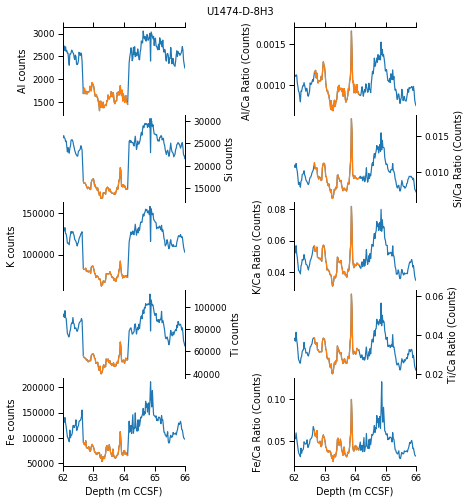

In [23]:
ids=xrf[xrf['SectionLabel'] == 'U1474D_8H3'].index

fig,axes=plt.subplots(ncols=2,nrows=5,figsize=(7,7),sharex=True)
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

for i in [0,1]:
    sns.despine(ax=axes[0,i],right=True,bottom=True,top=False)
    axes[0,i].patch.set_alpha(0)

for i in [0,1]:
    for i,ax in enumerate(axes[1:-1,i]):
        if i%2==1:
            sns.despine(ax=ax,bottom=True)
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)
        else:
            sns.despine(ax=ax,left=True,bottom=True,right=False)
            ax.yaxis.set_label_position("right")
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)

for i in [0,1]:
    axis=axes[-1,i]
    if len(axes)%2==1:
        sns.despine(ax=axis)
        axis.patch.set_alpha(0)
    else:
        sns.despine(ax=axis,left=True,right=False)
        axis.yaxis.set_label_position("right")
        axis.patch.set_alpha(0)
    
    
for i,e in enumerate(e_list):
    xrf[e].loc[62:66].plot(ax=axes[i,0])
    ((xrf[xrf['SectionLabel'] == 'U1474D_8H3'][e])).plot(ax=axes[i,0])
    axes[i,0].set_ylabel(e+' counts')
    axes[i,0].set_xlabel('')
axes[4,0].set_xlabel('Depth (m CCSF)')

for i,e in enumerate(e_list):
    (xrf[e]/xrf['Ca']).loc[62:66].plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_8H3'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_8H3']['Ca'])).plot(ax=axes[i,1])
    axes[i,1].set_ylabel(e+'/Ca Ratio (Counts)')
axes[4,0].set_xlabel('Depth (m CCSF)')
axes[4,1].set_xlabel('Depth (m CCSF)')
    
plt.suptitle('U1474-D-8H3',size=10)
plt.subplots_adjust(wspace=.9,hspace=0,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-6 problem_U1474-D-8H3.eps',dpi=1000,format='eps')

### Sections D11H4 and D11H5

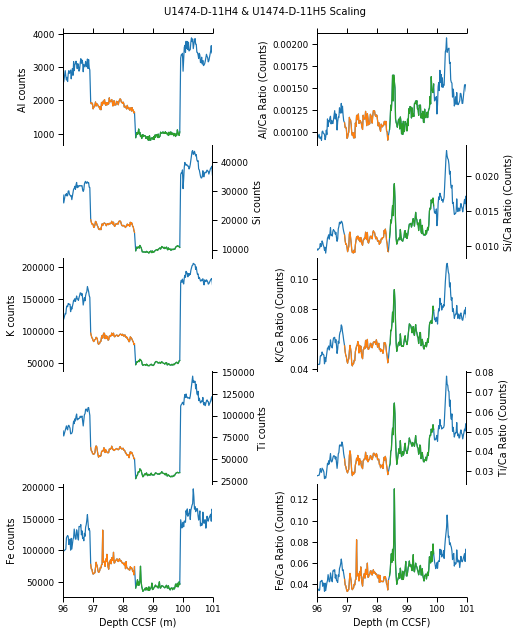

In [24]:
fig,axes=plt.subplots(ncols=2,nrows=5,figsize=(8,9),sharex=True)
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

for i in [0,1]:
    sns.despine(ax=axes[0,i],right=True,bottom=True,top=False)
    axes[0,i].patch.set_alpha(0)

for i in [0,1]:
    for i,ax in enumerate(axes[1:-1,i]):
        if i%2==1:
            sns.despine(ax=ax,bottom=True)
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)
        else:
            sns.despine(ax=ax,left=True,bottom=True,right=False)
            ax.yaxis.set_label_position("right")
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)

for i in [0,1]:
    axis=axes[-1,i]
    if len(axes)%2==1:
        sns.despine(ax=axis)
        axis.patch.set_alpha(0)
    else:
        sns.despine(ax=axis,left=True,right=False)
        axis.yaxis.set_label_position("right")
        axis.patch.set_alpha(0)
    
    
for i,e in enumerate(e_list):
    xrf[e].loc[96:101].plot(ax=axes[i,0])
    (xrf[xrf['SectionLabel'] == 'U1474D_11H4'][e]).plot(ax=axes[i,0])
    (xrf[xrf['SectionLabel'] == 'U1474D_11H5'][e]).plot(ax=axes[i,0])
    axes[i,0].set_ylabel(e+' counts')
    axes[i,0].set_xlabel('')
axes[4,0].set_xlabel('Depth CCSF (m)')

for i,e in enumerate(e_list):
    (xrf[e]/xrf['Ca']).loc[96:101].plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_11H4'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_11H4']['Ca'])).plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_11H5'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_11H5']['Ca'])).plot(ax=axes[i,1])
    axes[i,1].set_ylabel(e+'/Ca Ratio (Counts)')
axes[4,0].set_xlabel('Depth CCSF (m)')
    
plt.suptitle('U1474-D-11H4 & U1474-D-11H5 Scaling',size=10)
plt.subplots_adjust(wspace=.7,hspace=0,top=.94,bottom=.07,right=.85,left=.15)

# Visualize Ratios

No long sections have anomalously high MSE, which would be expected for a problematic section

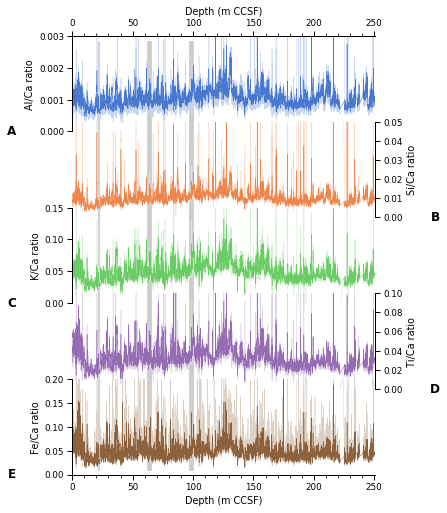

In [25]:
fig,axes=plt.subplots(nrows=5,figsize=(6,7))
sns.set_context('paper',font_scale=1)

lw=.5
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)

color_list=[0,1,2,4,5]
for i,e in enumerate(['Al','Si','K','Ti','Fe']):
    (xrf[e]/xrf['Ca']).plot(ax=axes[i],color=colors[color_list[i]],lw=lw)
    (old_xrf[e]/old_xrf['Ca']).plot(ax=axes[i],color=colors_pale[color_list[i]],lw=lw,zorder=-2)
    axes[i].set_ylabel(e+'/Ca ratio')
    axes[i].axvspan(xmin=21,xmax=22,ymin=.05,ymax=.95,color='#CCCCCC',zorder=-4)
    axes[i].axvspan(xmin=62,xmax=65,ymin=.05,ymax=.95,color='#CCCCCC',zorder=-4)
    axes[i].axvspan(xmin=97,xmax=100,ymin=.05,ymax=.95,color='#CCCCCC',zorder=-4)

labels=['A','C','E']
axs=[0,2,4]

for i in np.arange(0,3): 
    axes[axs[i]].annotate(labels[i],xy=(-.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')

labels=['B','D']
axs=[1,3]

for i in np.arange(0,2): 
    axes[axs[i]].annotate(labels[i],xy=(1+.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')
    
axes[0].set_ylim(0,.003)
axes[1].set_ylim(0,.05)
axes[2].set_ylim(0,.15)
axes[3].set_ylim(0,.1)
axes[4].set_ylim(0,0.2)

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth (m CCSF)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth (m CCSF)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-3 counts_ratios.eps',dpi=1000,format='eps')

# Compare XRF data to Calibration Dataset
It is common to calibrate X-Ray Flourescense data with well constrained concentration data. Here we provide elemental flux fusion concentrations of discrete sediment samples at different core depths for our calibration.
At this point, we can assess the quality of our raw data by comparing the xrf counts, relative abundances, to absolute concentrations from our calibration dataset
### Import Calibration Dataset

In [26]:
reference_conc_raw=pd.read_csv(table_path+'Table-2 calibration_samples.csv')
reference_conc_raw.set_index('Top Depth (m CCSF*)',inplace=True)
reference_conc=reference_conc_raw[['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']].copy()

In [27]:
e='CaO'
ref_conc_ratios=pd.DataFrame(index=reference_conc.index)
ref_conc_ratios[str('Al2O3/'+e)]=reference_conc['Al2O3']/reference_conc[e]
ref_conc_ratios[str('SiO2/'+e)]=reference_conc['SiO2']/reference_conc[e]
ref_conc_ratios[str('K2O/'+e)]=reference_conc['K2O']/reference_conc[e]
ref_conc_ratios[str('TiO2/'+e)]=reference_conc['TiO2']/reference_conc[e]
ref_conc_ratios[str('Fe2O3/'+e)]=reference_conc['Fe2O3']/reference_conc[e]

### Prepare "Counts" dataframe for comparison
We need to make an dataframe of xrf counts identical in size to the calibration data (reference_conc), extracted from the xrf counts dataframe at the depth of the calibration samples. This way, we can directly compare counts at a depth to concentration at a depth.
<br> cts_check will be this dataframe. Right now it is empty.

In [28]:
cts_check=pd.DataFrame(columns=['Al','Si','K','Ca','Ti','Fe'])

Here we first make a dataframe of just the elements we want from the clean xrf data. We then sort through this dataframe to find the depths of the calibration samples, and then add those measurements to the dataframe "cts_check"

In [29]:
xrf_check=xrf[['Al','Si','K','Ca','Ti','Fe']]
cts_check=xrf_check.reindex(reference_conc.index,method='nearest')
# for i in reference_conc.index:
#     idx=xrf_check.index.get_loc(i,method='nearest')
#     cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]
    
e='Ca'
cts_check_ratios=pd.DataFrame(index=cts_check.index)
cts_check_ratios[str('Al/'+e)]=cts_check['Al']/cts_check[e]
cts_check_ratios[str('Si/'+e)]=cts_check['Si']/cts_check[e]
cts_check_ratios[str('K/'+e)]=cts_check['K']/cts_check[e]
cts_check_ratios[str('Ti/'+e)]=cts_check['Ti']/cts_check[e]
cts_check_ratios[str('Fe/'+e)]=cts_check['Fe']/cts_check[e]

### Define function r2 to assess correlation

In [30]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

### Compare raw data and calibration data to assess quality

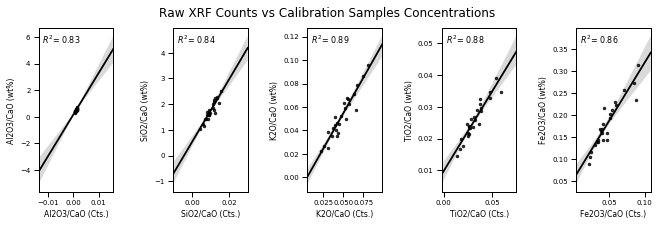

In [31]:
sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(10,3))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(1,5,i+1)
    sns.regplot(cts_check_ratios.iloc[:,i],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios.iloc[:,i],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' (wt%)')
    ax.set_xlabel(col+' (Cts.)')
plt.suptitle('Raw XRF Counts vs Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.2,wspace=.8,right=.95,left=.1)

## Convert counts to concentrations
We convert xrf counts, relative abundance, to absolute concentrations using the procedure of Weltje et al. (2008, Calibration of XRF core scanners for quantitative geochemical logging of sediment cores: Theory and application, _Earth and Planetary Science Letters_, https://doi.org/10.1016/j.epsl.2008.07.054). The procedure uses a Univariate log-ratio calibration. In our dataset, we compare all elements to Ca, as recommended by Weltje et al.

### Create dataframe of ratios from XRF core scans

In [32]:
e='Ca'
xrf_ratios=pd.DataFrame(index=xrf.index)
xrf_ratios[str('Al/'+e)]=xrf['Al']/xrf[e]
xrf_ratios[str('Si/'+e)]=xrf['Si']/xrf[e]
xrf_ratios[str('K/'+e)]=xrf['K']/xrf[e]
xrf_ratios[str('Ca/'+e)]=xrf['Ca']/xrf[e]
xrf_ratios[str('Ti/'+e)]=xrf['Ti']/xrf[e]
xrf_ratios[str('Fe/'+e)]=xrf['Fe']/xrf[e]

### Create dataframe of ratios from Flux Fusion Calibration Dataset

In [33]:
e='CaO'
ref_conc_ratios=pd.DataFrame(index=reference_conc.index)
ref_conc_ratios[str('Al2O3/'+e)]=reference_conc['Al2O3']/reference_conc[e]
ref_conc_ratios[str('SiO2/'+e)]=reference_conc['SiO2']/reference_conc[e]
ref_conc_ratios[str('K2O/'+e)]=reference_conc['K2O']/reference_conc[e]
ref_conc_ratios[str('TiO2/'+e)]=reference_conc['TiO2']/reference_conc[e]
ref_conc_ratios[str('Fe2O3/'+e)]=reference_conc['Fe2O3']/reference_conc[e]

### Extract XRF core scan ratio at depth of calibrations samples
First extract counts at depth

In [34]:
cts_check=pd.DataFrame(columns=reference_conc.columns)
cts_check_ratios=xrf_ratios.reindex(ref_conc_ratios.index,method='nearest',tolerance=.02)
cts_check_ratios.rename(columns={'Al/Ca':'Al2O3/CaO','Si/Ca':'SiO2/CaO','K/Ca':'K2O/CaO',
                                 'Ca/Ca':'CaO/CaO','Ti/Ca':'TiO2/CaO','Fe/Ca':'Fe2O3/CaO'},inplace=True)

### Parameter Estimation
These are the parameters of the univariate log-ratio calibration of Weltje et al. 2008, as described in the supplementary information.

In [35]:
yis={}
for ratio in ref_conc_ratios.columns:
    yis[ratio]=np.array([np.log(ref_conc_ratios[ratio]),np.log(cts_check_ratios[ratio])]).transpose()
    
y_bars={}
for ratio in ref_conc_ratios.columns:
    y_bars[ratio]=np.array([yis[ratio][:,0].mean(),yis[ratio][:,1].mean()])
    
xis={}
for ratio in ref_conc_ratios.columns:
    xis[ratio]=np.array([yis[ratio][:,0]-y_bars[ratio][0],yis[ratio][:,1]-y_bars[ratio][1]]).transpose()
    
xtxs={}
for ratio in ref_conc_ratios.columns:
    xtxs[ratio]=np.dot(xis[ratio].transpose(),xis[ratio])

Fs={}
for ratio in ref_conc_ratios.columns:
    Fs[ratio]=(xtxs[ratio][0,0]-xtxs[ratio][1,1])/(2*xtxs[ratio][1,0])

Gs={}
for ratio in ref_conc_ratios.columns:
    Gs[ratio]=Fs[ratio]+np.sqrt(np.square(Fs[ratio])+1)

a_s={}
for ratio in ref_conc_ratios.columns:
    a_s[ratio]=Gs[ratio]/(np.sqrt(Gs[ratio])+1)
    
b_s={}
for ratio in ref_conc_ratios.columns:
    b_s[ratio]=1/(np.sqrt(Gs[ratio])+1)

alphas={}
for ratio in ref_conc_ratios.columns:
    alphas[ratio]=a_s[ratio]/b_s[ratio]
betas={}
for ratio in ref_conc_ratios.columns:
    betas[ratio]=y_bars[ratio][0]-alphas[ratio]*y_bars[ratio][1]

In [36]:
a='α'
b='β'
pd.DataFrame([alphas,betas],index=[a,b]).to_csv(table_path+'Table-7 alpha_beta.csv')

In [37]:
betas

{'Al2O3/CaO': 4.211941301157898,
 'SiO2/CaO': 3.828742307894333,
 'K2O/CaO': 0.6946830667825941,
 'TiO2/CaO': -1.370013932995771,
 'Fe2O3/CaO': 0.662594659313114}

## Log XRF Scans

In [38]:
xrf_ratios.rename(columns={'Al/Ca':'Al2O3/CaO','Si/Ca':'SiO2/CaO','K/Ca':'K2O/CaO',
                                 'Ca/Ca':'CaO/CaO','Ti/Ca':'TiO2/CaO','Fe/Ca':'Fe2O3/CaO'},inplace=True)
xrf_log=np.log(xrf_ratios)

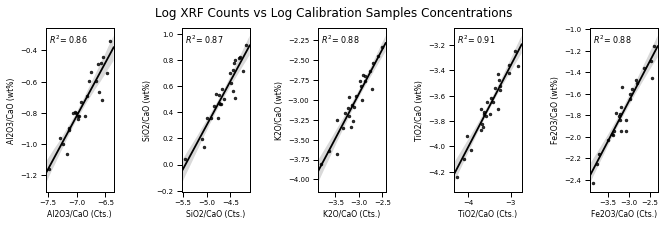

In [39]:
sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(10,3))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(1,5,i+1)
    sns.regplot(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col]),
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col])).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' (wt%)')
    ax.set_xlabel(col+' (Cts.)')
plt.suptitle('Log XRF Counts vs Log Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.2,wspace=1,right=.95,left=.1)

## Calibrate XRF Scans

In [40]:
ln_wij_over_wid_xrf={}
for ratio in ref_conc_ratios.columns:
    ln_wij_over_wid_xrf[ratio]=alphas[ratio]*xrf_log[ratio]+betas[ratio]

In [41]:
df_ln_wij_over_wid_xrf=pd.DataFrame(ln_wij_over_wid_xrf)
df_ln_wij_over_wid_xrf=df_ln_wij_over_wid_xrf[[str('Al2O3/'+e),str('SiO2/'+e),
                                               str('K2O/'+e),
                                               str('TiO2/'+e),str('Fe2O3/'+e)]]
df_ln_wij_over_wid_xrf[str(e+'/'+e)]=0

### Get out of log space and into concentrations

In [42]:
tot=reference_conc[['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']].sum(axis=1).mean()

In [43]:
calibrated=np.exp(df_ln_wij_over_wid_xrf).div(np.exp(df_ln_wij_over_wid_xrf).sum(axis=1),axis=0)*100
calibrated=calibrated/100*tot
calibrated.rename(columns={'Al2O3/CaO':'Al2O3','SiO2/CaO':'SiO2','K2O/CaO':'K2O',
                          'TiO2/CaO':'TiO2','Fe2O3/CaO':'Fe2O3','CaO/CaO':'CaO'},inplace=True)

In [44]:
calibrated_ratios=np.exp(df_ln_wij_over_wid_xrf)

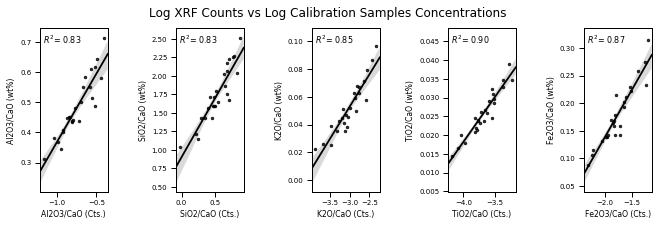

In [45]:
cts_check_ratios=df_ln_wij_over_wid_xrf.reindex(ref_conc_ratios.index,method='nearest',tolerance=.02)

sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(10,3))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(1,5,i+1)
    sns.regplot(cts_check_ratios[col],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios[col],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' (wt%)')
    ax.set_xlabel(col+' (Cts.)')
plt.suptitle('Log XRF Counts vs Log Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.2,wspace=1,right=.95,left=.1)

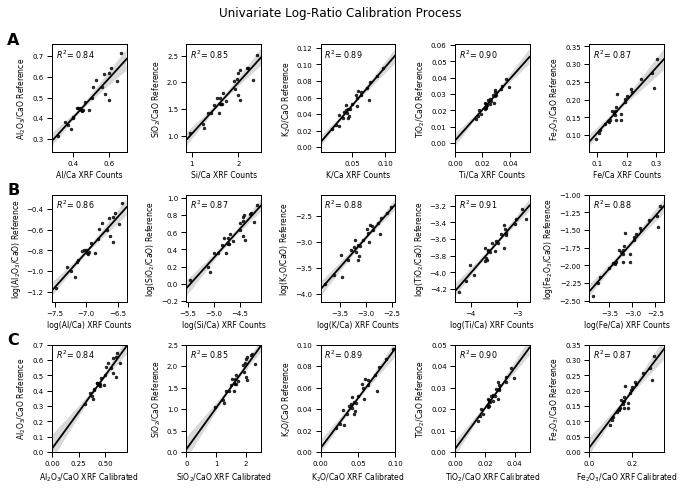

In [72]:
label_list=['Al/Ca','Si/Ca','K/Ca','Ti/Ca','Fe/Ca']
oxide_labels=['Al$_2$O$_3$/CaO','SiO$_2$/CaO','K$_2$O/CaO','TiO$_2$/CaO','Fe$_2$O$_3$/CaO']
sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=3,figsize=(10,7.5))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(3,5,i+1)
    sns.regplot(cts_check_ratios[col],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios[col],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(oxide_labels[i]+' Reference')
    ax.set_xlabel(label_list[i]+' XRF Counts')
    
ax.annotate('A',xy=(-7.8,1),xycoords='axes fraction',size=16,fontweight='bold')

cts_check_ratios=xrf_ratios.reindex(ref_conc_ratios.index,method='nearest')

for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(3,5,i+6)
    sns.regplot(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col]),
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col])).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel('log('+oxide_labels[i]+') Reference')
    ax.set_xlabel('log('+label_list[i]+') XRF Counts')

ax.annotate('B',xy=(-7.8,1),xycoords='axes fraction',size=16,fontweight='bold')
    
cts_check_ratios=calibrated_ratios.reindex(ref_conc_ratios.index,method='nearest')
lims=[(0,.7),(0,2.5),(0,.1),(0,.05),(0,.35)]

for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(3,5,i+11)
    ax.set_xlim(lims[i][0],lims[i][1])
    ax.set_ylim(lims[i][0],lims[i][1]) 
    sns.regplot(cts_check_ratios[col],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios[col],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(oxide_labels[i]+' Reference')
    ax.set_xlabel(oxide_labels[i]+' XRF Calibrated')
   
    
ax.annotate('C',xy=(-7.8,1),xycoords='axes fraction',size=16,fontweight='bold')
    
plt.suptitle('Univariate Log-Ratio Calibration Process',size=12,y=.95)
plt.subplots_adjust(hspace=.4,wspace=.8,right=.95,left=.1)
# fig.savefig(figure_path+'Figure-7 process.jpg',quality=95)
fig.savefig(figure_path+'Figure-7 process.pdf', bbox_inches='tight')

# View
## CaCO3 Comparison

In [56]:
CaCO3=pd.read_csv(table_path+'Table-3 carbonate_data_u1474.csv',skipfooter=1,index_col='Best Depth (m CCSF)',
                 engine='python')
CaCO3['%err']=CaCO3['σ %CaCO3']/CaCO3['%CaCO3']
CaCO3.sort_index(inplace=True)

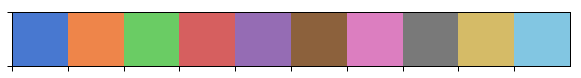

In [57]:
colors=sns.color_palette('muted',10)
sns.palplot(colors)

In [58]:
CaCO3['xrf_Ca']=calibrated.reindex(CaCO3.index,method='nearest')['CaO']
CaCO3['coul_Ca']=CaCO3['%CaCO3']*.4/.714
CaCO3['Terrigenous_Ca']=CaCO3['xrf_Ca']-CaCO3['coul_Ca']

In [59]:
calibrated_CaCO3=calibrated.reindex(CaCO3.index,method='nearest').dropna()
calibrated_CaCO3['Ca/Fe']=calibrated_CaCO3['CaO']/calibrated_CaCO3['Fe2O3']*.714/.69

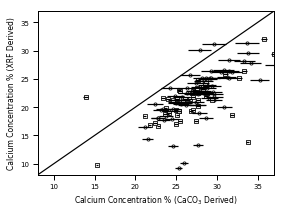

In [60]:
fig,ax=plt.subplots(figsize=(4,3))
df=CaCO3[CaCO3['Source']=='This Study']
# df.plot.scatter(x='xrf_Ca',y='coul_Ca',s=10,ax=ax,xerr=df['%err']*df['coul_Ca'],
#                 color='white',edgecolor='k',ecolor='k')
ax.scatter(df['xrf_Ca'],df['coul_Ca'],s=10,color='white',edgecolor='k')
ax.errorbar(df['xrf_Ca'],df['coul_Ca'],xerr=df['%err']*df['coul_Ca'],ecolor='k',ls='')

df=CaCO3[CaCO3['Source']=='IODP']
ax.scatter(df['xrf_Ca'],df['coul_Ca'],s=10,color='white',edgecolor='k',marker='s')
ax.errorbar(df['xrf_Ca'],df['coul_Ca'],xerr=df['%err']*df['coul_Ca'],ecolor='k',ls='')

ax.plot([0,40],[0,40],color='k')
ax.set_ylabel('Calcium Concentration % (XRF Derived)')
ax.set_xlabel('Calcium Concentration % (CaCO$_3$ Derived)')
ax.set_ylim(8,37)
ax.set_xlim(8,37)
plt.tight_layout()
fig.savefig(figure_path+'Figure-9 Ca_vs_Ca.eps',dpi=1000,format='eps')

# Elements by Depth
Strange titanium

In [61]:
ids=calibrated[calibrated['TiO2']>1.1].index
calibrated.drop(ids,inplace=True)

In [62]:
ids=calibrated[calibrated['Fe2O3']>10.5].index
calibrated.drop(ids,inplace=True)

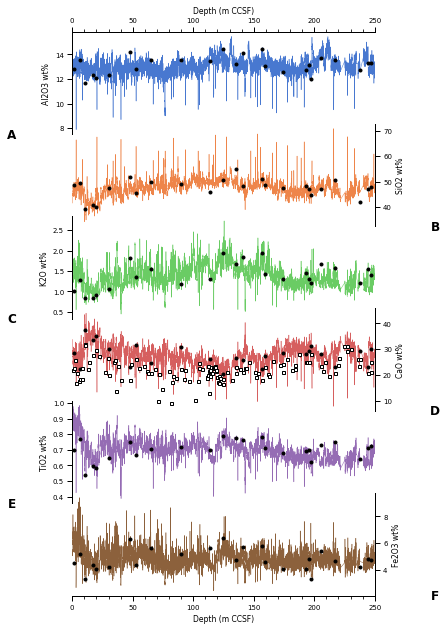

In [63]:
fig,axes=plt.subplots(nrows=6,figsize=(6,9))
sns.set_context('paper',font_scale=.8)

lw=.5
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)

x1=0
x2=250

for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)
    
for i,e in enumerate(['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']):
    calibrated[e].loc[x1:x2].plot(ax=axes[i],color=colors[i],lw=lw)
    reference_conc.iloc[:,i].loc[x1:x2].plot(ax=axes[i],ls='',marker='o',color='k',
                                       markeredgecolor='k',markeredgewidth=1,ms=2*ms)
    axes[i].set_ylabel(e+' wt%')

(CaCO3['%CaCO3']*.4/.714).loc[:250].loc[x1:x2].plot(ax=axes[3],marker='s',ls='',color='white',markeredgecolor='k',ms=2*ms)

axes[0].annotate('A',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[1].annotate('B',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[2].annotate('C',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[3].annotate('D',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[4].annotate('E',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[5].annotate('F',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth (m CCSF)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth (m CCSF)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-4 concentrations.eps',dpi=1000,format='eps')

## Ratios by Depth

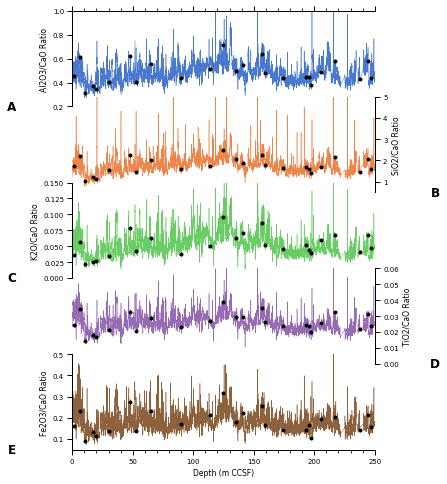

In [64]:
fig,axes=plt.subplots(nrows=5,figsize=(6,7),sharex=True)
sns.set_context('paper',font_scale=.8)

lw=.5
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)

for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)
    
es=['Al2O3', 'SiO2', 'K2O', 'TiO2', 'Fe2O3']
lims=[(.2,1),(.5,5),(0,.15),(0,.06),(0.05,.5)]

color_list=[0,1,2,4,5]
for i,e in enumerate(['Al2O3','SiO2','K2O','TiO2','Fe2O3']):
    (calibrated[e]/calibrated['CaO']).loc[x1:x2].plot(ax=axes[i],color=colors[color_list[i]],lw=lw)
    (reference_conc[es[i]]/reference_conc['CaO']).loc[x1:x2].plot(ax=axes[i],ls='',marker='o',color='k',
                                       markeredgecolor='k',markeredgewidth=1,ms=2*ms)
    axes[i].set_ylabel(e+'/CaO Ratio')
    axes[i].set_ylim(lims[i])

axes[0].annotate('A',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[1].annotate('B',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[2].annotate('C',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[3].annotate('D',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[4].annotate('E',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')


axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth (m CCSF)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth (m CCSF)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-5 concentrations_ratios.eps',dpi=1000,format='eps')

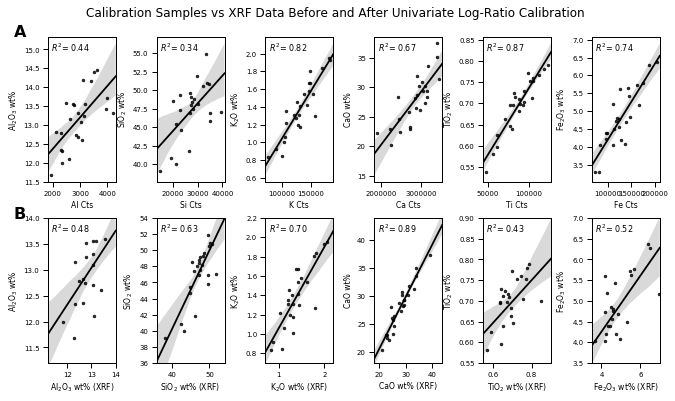

In [73]:
cts_check=xrf.reindex(reference_conc.index,method='nearest')
cts_check=cts_check[['Al','Si','K','Ca','Ti','Fe']]
axes_labels=['Al$_2$O$_3$','SiO$_2$','K$_2$O','CaO','TiO$_2$','Fe$_2$O$_3$']

sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=6,nrows=2,figsize=(10,6))
for i,col in enumerate(cts_check.columns):
    ax=plt.subplot(2,6,i+1)
    sns.regplot(cts_check[col],reference_conc.iloc[:,i],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc.iloc[:,i]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(axes_labels[i]+' wt%')
    ax.set_xlabel(col+' Cts')
    
ax.annotate('A',xy=(-8.5,1),xycoords='axes fraction',size=16,fontweight='bold')


cts_check=calibrated.reindex(reference_conc.index,method='nearest')
cts_check=cts_check[['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']]
lims=[(11.2,14),(36,54),(.7,2.2),(18,44),(.55,.9),(3.5,7)]

for i,col in enumerate(cts_check.columns):
    ax=plt.subplot(2,6,i+7)
    ax.set_xlim(lims[i][0],lims[i][1])
    ax.set_ylim(lims[i][0],lims[i][1])
    sns.regplot(cts_check[col],reference_conc.iloc[:,i],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc.iloc[:,i]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(axes_labels[i]+' wt%')
    ax.set_xlabel(axes_labels[i]+' wt% (XRF)')

    
ax.annotate('B',xy=(-8.5,1),xycoords='axes fraction',size=16,fontweight='bold')
    
plt.suptitle('Calibration Samples vs XRF Data Before and After Univariate Log-Ratio Calibration',size=12,y=.95)
plt.subplots_adjust(hspace=.25,wspace=.6,right=.95,left=.1)

fig.savefig(figure_path+'Figure-8 before_after.pdf',bbox_inches='tight')

## Export

In [66]:
columns=['Depth (m CCSF)', 'Exp', 'Site', 'Hole', 'Type', 'Section',
       'SectionLabel', 'Top Offset (cm)','MSE']

In [67]:
final=calibrated.copy()

In [68]:
final[columns]=xrf[columns]

In [69]:
final=final[['Exp','Site', 'Hole', 'Type', 'Section', 'SectionLabel', 'Top Offset (cm)','Depth (m CCSF)',
       'MSE','Al2O3', 'SiO2', 'K2O', 'TiO2', 'Fe2O3', 'CaO']]

In [70]:
final=final.sort_index()
final=final[~final.index.duplicated(keep='first')].copy()

In [71]:
final.to_csv(table_path+'Table-6 calibrated xrf data.csv',index=False)
u1474_path='/Users/danielbabin/Documents/LamontColumbia/U1474_Paper/Data/'
u1474_git_path='/Users/danielbabin/Documents/GitHub/P-Pl_Natal_Valley/Data/'
final.to_csv(u1474_path+'xrf_calibrated.csv',index=False)
final.to_csv(u1474_git_path+'xrf_calibrated.csv',index=False)